In [1]:
import fastai
from fastai.vision.all import *
from fastai.callback.wandb import *

print(fastai.__version__)

2.5.0


In [2]:
import pandas as pd

df = pd.read_csv('wandb_cassava_train_val_split.csv')
df.head()

,image_id,label,is_val
0,1000015157.jpg,0,False
1,1000201771.jpg,3,False
2,100042118.jpg,1,False
3,1000723321.jpg,1,False
4,1000812911.jpg,3,False


In [3]:
def splitter(df):
    train = df.index[~df['is_val']].tolist()
    valid = df.index[df['is_val']].tolist()
    return train, valid

In [4]:
path = Path()
def get_x(row):
    return path/'train_images'/row['image_id']

def get_y(row):
    return row['label']

In [5]:
def get_dls(size=224, presize=460, bs=64):
    db = DataBlock(
                  blocks = (ImageBlock, CategoryBlock),
                  get_x = get_x,
                  get_y = get_y,
                  splitter = splitter,
                  item_tfms = [Resize(presize)],
                  batch_tfms = [*aug_transforms(size=size), Normalize.from_stats(*imagenet_stats)]
                )
    return db.dataloaders(df, bs=bs)

/home/i322118/anaconda3/envs/cassava-clf/lib/python3.7/site-packages/torch/_tensor.py:1023: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  /pytorch/aten/src/ATen/native/BatchLinearAlgebra.cpp:760.)
  ret = func(*args, **kwargs)


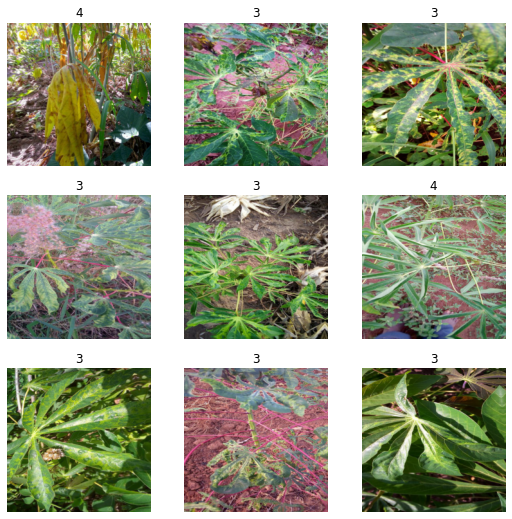

In [6]:
dls = get_dls(size=224, presize=460, bs=64)
dls.show_batch()

In [7]:
learn = cnn_learner(dls, resnet50, metrics=accuracy)

Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /home/i322118/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

/home/i322118/anaconda3/envs/cassava-clf/lib/python3.7/site-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


/home/i322118/anaconda3/envs/cassava-clf/lib/python3.7/site-packages/fastai/callback/schedule.py:270: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  ax.plot(val, idx, 'ro', label=nm, c=color)


SuggestedLRs(valley=0.0020892962347716093)

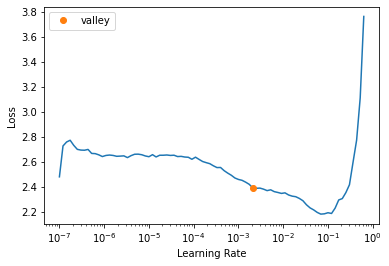

In [8]:
learn.lr_find()

In [9]:
learn.fit_one_cycle(15, 2e-3)

epoch,train_loss,valid_loss,accuracy,time
0,1.334056,0.934803,0.714887,03:13
1,0.831297,0.691847,0.774480,03:12
2,0.635915,0.549400,0.813508,03:14
3,0.549636,0.516897,0.831269,03:14
4,0.498941,0.508619,0.827530,03:13
5,0.484030,0.480811,0.831269,03:14
6,0.456951,0.486462,0.832905,03:14
7,0.414097,0.470169,0.843421,03:14
8,0.402916,0.436164,0.849965,03:14
9,0.384304,0.428638,0.858144,03:13


In [10]:
learn.save("pr-224")

Path('models/pr-224.pth')

In [11]:
learn.unfreeze()

SuggestedLRs(valley=1.4454397387453355e-05)

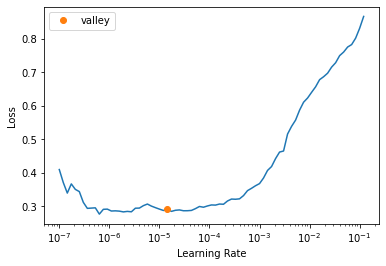

In [12]:
learn.lr_find()

In [13]:
learn.dls = get_dls(size=448, presize=560, bs=32)

In [ ]:
learn.fit_one_cycle(5, lr_max=slice(1e-6,1e-4))

epoch,train_loss,valid_loss,accuracy,time
0,0.381326,0.376921,0.876373,13:58
1,0.342633,0.372094,0.877074,13:50
2,0.338595,0.369840,0.877308,13:51
3,0.304467,0.356885,0.881281,13:51


In [16]:
learn.validate()

(#2) [0.35694417357444763,0.8815143704414368]

In [17]:
learn.save("pr-448")

Path('models/pr-448.pth')

In [19]:
accuracy(*learn.tta()).item()

0.885019838809967